In [164]:
import os

import kagglehub
import numpy as np
import pandas as pd
from dataclasses import dataclass
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from typing_extensions import override

PATH_TO_DATASET = os.path.join(kagglehub.dataset_download("salvatorerastelli/spotify-and-youtube"),
                               "Spotify_Youtube.csv")

# Reading the dataset
While dropping unneeded columns, similarly to the first part. Additional columns that are dropped: 'Artist'

In [3]:
df = pd.read_csv(PATH_TO_DATASET)
NUMERIC_COLUMNS = ['Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
                   'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Views', 'Likes', 'Comments', 'Stream']
CATEGORICAL_COLUMNS = ['Album_type', 'Licensed', 'official_video']
df.drop(
    columns=['Description', 'Url_youtube', 'Url_spotify', 'Uri', 'Title', 'Channel', 'Album', 'Track', 'Unnamed: 0', 'Artist'],
    axis=1, inplace=True)
df.describe()

,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Views,Likes,Comments,Stream
count,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,2.071600e+04,2.024800e+04,2.017700e+04,2.014900e+04,2.014200e+04
mean,0.619777,0.635250,5.300348,-7.671680,0.096456,0.291535,0.055962,0.193521,0.529853,120.638340,2.247176e+05,9.393782e+07,6.633411e+05,2.751899e+04,1.359422e+08
std,0.165272,0.214147,3.576449,4.632749,0.111960,0.286299,0.193262,0.168531,0.245441,29.579018,1.247905e+05,2.746443e+08,1.789324e+06,1.932347e+05,2.441321e+08
min,0.000000,0.000020,0.000000,-46.251000,0.000000,0.000001,0.000000,0.014500,0.000000,0.000000,3.098500e+04,0.000000e+00,0.000000e+00,0.000000e+00,6.574000e+03
25%,0.518000,0.507000,2.000000,-8.858000,0.035700,0.045200,0.000000,0.094100,0.339000,97.002000,1.800095e+05,1.826002e+06,2.158100e+04,5.090000e+02,1.767486e+07
50%,0.637000,0.666000,5.000000,-6.536000,0.050500,0.193000,0.000002,0.125000,0.537000,119.965000,2.132845e+05,1.450110e+07,1.244810e+05,3.277000e+03,4.968298e+07
75%,0.740250,0.798000,8.000000,-4.931000,0.103000,0.477250,0.000463,0.237000,0.726250,139.935000,2.524430e+05,7.039975e+07,5.221480e+05,1.436000e+04,1.383581e+08
max,0.975000,1.000000,11.000000,0.920000,0.964000,0.996000,1.000000,1.000000,0.993000,243.372000,4.676058e+06,8.079649e+09,5.078865e+07,1.608314e+07,3.386520e+09


### Normalizing Loudness metric


In [4]:
df['Loudness']= MinMaxScaler(feature_range=(0, 1)).fit_transform(df[['Loudness']])
df.describe()

,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Views,Likes,Comments,Stream
count,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,2.071600e+04,2.024800e+04,2.017700e+04,2.014900e+04,2.014200e+04
mean,0.619777,0.635250,5.300348,0.817861,0.096456,0.291535,0.055962,0.193521,0.529853,120.638340,2.247176e+05,9.393782e+07,6.633411e+05,2.751899e+04,1.359422e+08
std,0.165272,0.214147,3.576449,0.098212,0.111960,0.286299,0.193262,0.168531,0.245441,29.579018,1.247905e+05,2.746443e+08,1.789324e+06,1.932347e+05,2.441321e+08
min,0.000000,0.000020,0.000000,0.000000,0.000000,0.000001,0.000000,0.014500,0.000000,0.000000,3.098500e+04,0.000000e+00,0.000000e+00,0.000000e+00,6.574000e+03
25%,0.518000,0.507000,2.000000,0.792712,0.035700,0.045200,0.000000,0.094100,0.339000,97.002000,1.800095e+05,1.826002e+06,2.158100e+04,5.090000e+02,1.767486e+07
50%,0.637000,0.666000,5.000000,0.841937,0.050500,0.193000,0.000002,0.125000,0.537000,119.965000,2.132845e+05,1.450110e+07,1.244810e+05,3.277000e+03,4.968298e+07
75%,0.740250,0.798000,8.000000,0.875962,0.103000,0.477250,0.000463,0.237000,0.726250,139.935000,2.524430e+05,7.039975e+07,5.221480e+05,1.436000e+04,1.383581e+08
max,0.975000,1.000000,11.000000,1.000000,0.964000,0.996000,1.000000,1.000000,0.993000,243.372000,4.676058e+06,8.079649e+09,5.078865e+07,1.608314e+07,3.386520e+09


### Scaling the overly spread metrics: Likes, Views, Comments and Streams
In contrast to the first part, the values will be scaled using a logarithmic scale instead of the outliers being capped, with the bottom 3% being dropped completely (songs with a dismal amount of attention).

In [5]:
display("Size before dropping outliers: ", df.shape)
thresholds = {column_name: df[column_name].quantile(0.03) for column_name in ['Views', 'Likes', 'Comments', 'Stream']}
mask = df[list(thresholds.keys())].gt(pd.Series(thresholds)).all(axis=1)
df = df[mask]
display("Size after dropping outliers: ", df.shape)

'Size before dropping outliers: '

(20718, 18)

'Size after dropping outliers: '

(18187, 18)

In [6]:
df.loc[:, 'Views'] = np.log10(df['Views'])
df.loc[:, 'Likes'] = np.log10(df['Likes'])
df.loc[:, 'Comments'] = np.log10(df['Comments'])
df.loc[:, 'Stream'] = np.log10(df['Stream'])
df.describe()

,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Views,Likes,Comments,Stream
count,18186.000000,18186.000000,18186.000000,18186.000000,18186.000000,18186.000000,18186.000000,18186.000000,18186.000000,18186.000000,1.818600e+04,18187.000000,18187.000000,18187.000000,18187.000000
mean,0.624021,0.640492,5.308644,0.823122,0.092491,0.282504,0.049100,0.190521,0.532134,120.834939,2.260323e+05,7.139007,5.100764,3.531662,7.743577
std,0.162479,0.207076,3.575914,0.089913,0.094687,0.279682,0.180283,0.164621,0.242895,29.389313,1.240275e+05,1.030558,0.931282,0.984654,0.623354
min,0.000000,0.001250,0.000000,0.091560,0.000000,0.000002,0.000000,0.014500,0.000000,0.000000,3.500000e+04,4.260167,2.413300,0.477121,6.189394
25%,0.522000,0.517000,2.000000,0.798075,0.035500,0.043700,0.000000,0.094000,0.343000,97.028000,1.819910e+05,6.465060,4.519001,2.924796,7.319701
50%,0.640000,0.668000,5.000000,0.843665,0.050600,0.186000,0.000002,0.125000,0.538000,119.973000,2.144520e+05,7.255736,5.183307,3.609594,7.743738
75%,0.743000,0.797000,8.000000,0.876768,0.103000,0.458000,0.000342,0.232000,0.728000,139.969000,2.527330e+05,7.893353,5.760114,4.209917,8.172799
max,0.975000,1.000000,11.000000,1.000000,0.944000,0.996000,1.000000,1.000000,0.993000,243.372000,4.581483e+06,9.907393,7.705767,7.206371,9.529754


### Reducing the skew of the data

#### Goal: |Skewness| < 2.0
Columns 'Intrumentalness', 'Loudness', 'Liveness' and 'Speechiness' have a highly skewed distribution that will affect the machine learning models.
Column describing the duration of the song has a skewness of over 24 – with approximately the top 1% amounting to all the skew.
Histograms displaying the skew below.

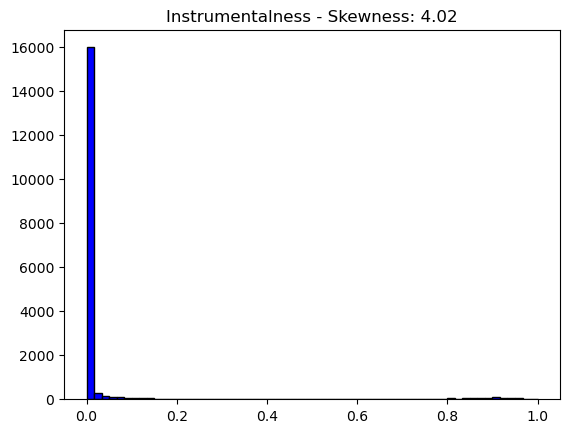

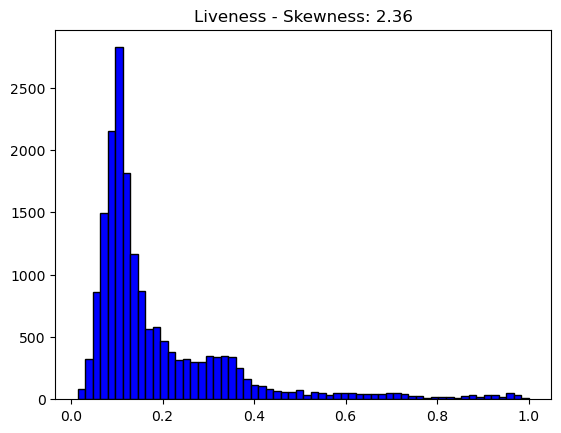

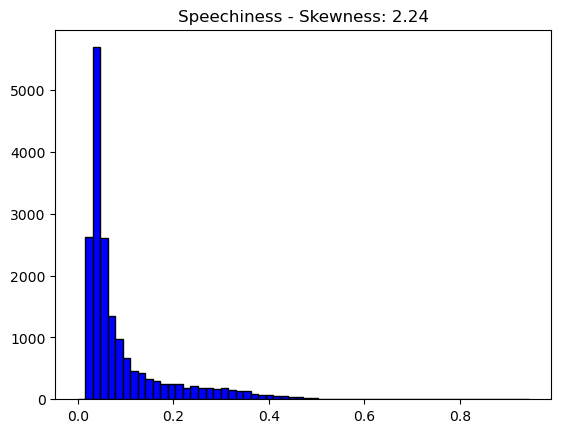

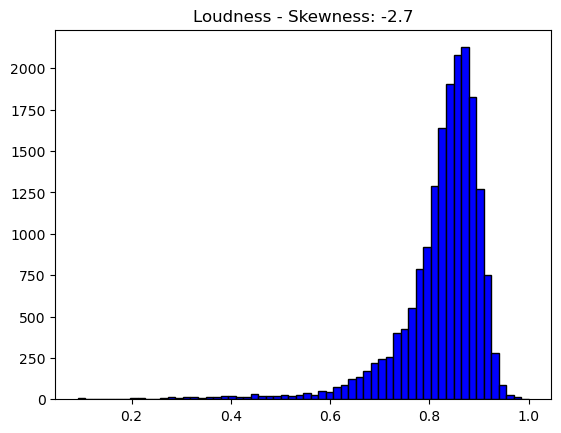

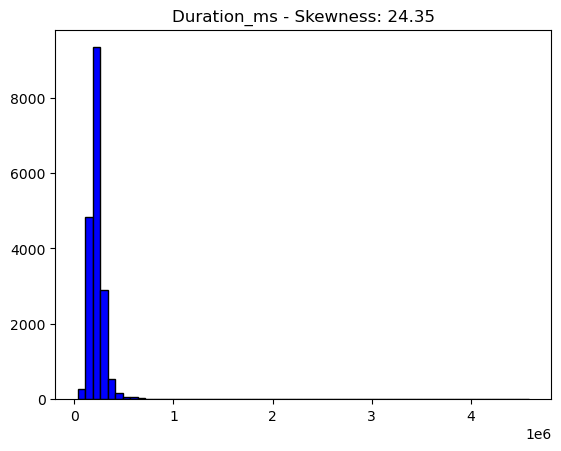

In [7]:
for column in ['Instrumentalness', 'Liveness', 'Speechiness', 'Loudness', 'Duration_ms']:
    plt.hist(df[column], bins=60, color='blue', edgecolor='black')
    plt.title(f'{column} - Skewness: {str(round(df[column].skew(), 2))}')
    plt.plot()
    plt.show()
    plt.close()

### Redefining the 'Instrumentalness' metric
The value of the metric is either extremely close to zero or, with a tiny number of songs, close to one. As such, it will be replaced with a binary variable.
- Value < 0.1 → False
- Value >= 0.1 → True


New metric name: `IsInstrumental`

In [8]:
df['Instrumentalness']=  df['Instrumentalness'].apply(lambda x: True if x is not None and x >= 0.1 else False)
display(df['Instrumentalness'].isnull().sum())
print(df['Instrumentalness'].value_counts())
print(df['Instrumentalness'])
NUMERIC_COLUMNS.remove('Instrumentalness')
CATEGORICAL_COLUMNS.append('Instrumentalness')

np.int64(0)

Instrumentalness
False    16726
True      1461
Name: count, dtype: int64
0        False
1        False
2        False
3         True
4        False
         ...  
20694    False
20695    False
20696    False
20697    False
20698    False
Name: Instrumentalness, Length: 18187, dtype: bool


### Reducing the right (positive) skews for 'Liveness', 'Speechiness'
Using Square Root Transformation since the data is not extremely skewed.

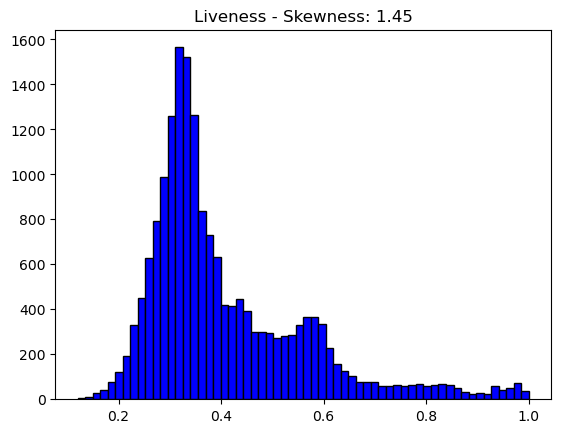

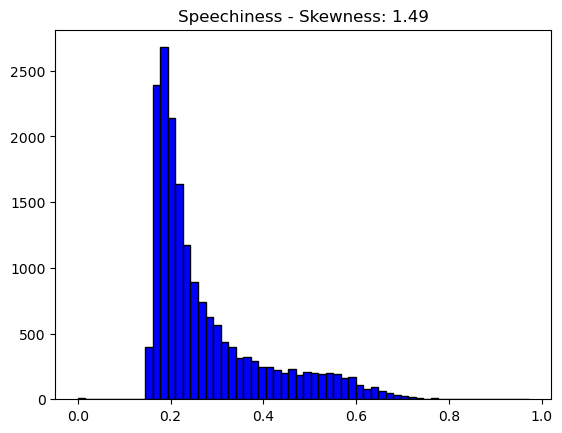

In [9]:
for column in ['Liveness', 'Speechiness']:
    df[column] = np.sqrt(df[column])
    plt.hist(df[column], bins=60, color='blue', edgecolor='black')
    plt.title(f'{column} - Skewness: {str(round(df[column].skew(), 2))}')
    plt.plot()
    plt.show()
    plt.close()

##### Capping the top outliers for duration
Value `0.987` was chosen to provide the best compromise between reducing the skew and retaining the data distribution.

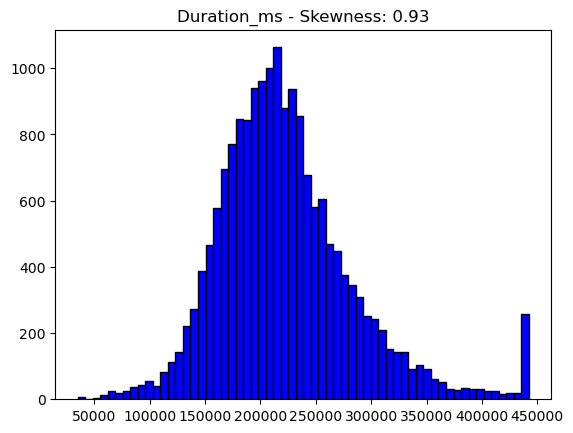

In [10]:
threshold = df['Duration_ms'].quantile(0.987)
df['Duration_ms'] = df['Duration_ms'].clip(upper=threshold)
plt.hist(df['Duration_ms'], bins=60, color='blue', edgecolor='black')
plt.title(f'Duration_ms - Skewness: {str(round(df['Duration_ms'].skew(), 2))}')
plt.plot()
plt.show()
plt.close()

### Reducing the left (negative) skews for 'Loudness'
Using lower Winsorization to limit the close to zero values. `0.013` chosen to reduce the skew under 2.0 without capping too many values.

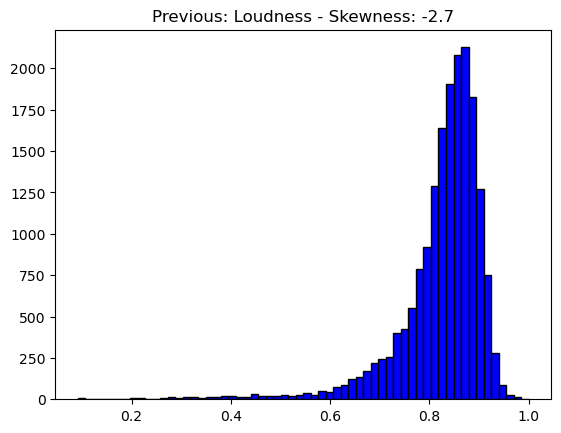

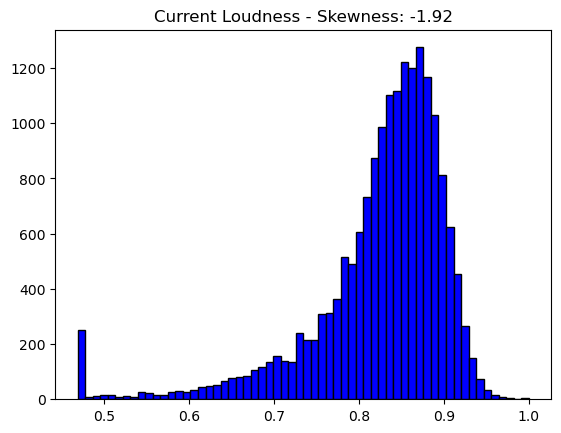

In [11]:
plt.hist(df['Loudness'], bins=60, color='blue', edgecolor='black')
plt.title(f'Previous: Loudness - Skewness: {str(round(df['Loudness'].skew(), 2))}')
plt.plot()
plt.show()
plt.close()
df['Loudness'] = df['Loudness'].clip(lower=df['Loudness'].quantile(0.013))
plt.hist(df['Loudness'], bins=60, color='blue', edgecolor='black')
plt.title(f'Current Loudness - Skewness: {str(round(df['Loudness'].skew(), 2))}')
plt.plot()
plt.show()
plt.close()

# Creating the pipelines

### Separate features and the target

In [12]:
target = 'Instrumentalness' #or official_video
X = df.drop(columns=[target], axis=1)
y = df[target]
NEW_CATEGORICAL_COLUMNS = CATEGORICAL_COLUMNS.copy()
NEW_CATEGORICAL_COLUMNS.remove(target)

### Create preprocessing pipelines


In [13]:
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_pipeline, NUMERIC_COLUMNS),
        ('categorical', categorical_pipeline, NEW_CATEGORICAL_COLUMNS),
    ]
)

#### Define the model pipeline

In [15]:
model_pipelines: dict[str, Pipeline] = {}

def add_model_pipeline(classifier, name: str):
    model_pipelines[name] = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

In [16]:
add_model_pipeline(LogisticRegression(max_iter=1000), 'logReg')
add_model_pipeline(RandomForestClassifier(random_state=42), 'rfc')
add_model_pipeline(SVC(), 'svc')

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.2, random_state=42)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

#### Train the model

In [18]:
for pipeline in model_pipelines.values():
    pipeline.fit(X_train, y_train)

#### Training set results


In [19]:
for pipeline_name, pipeline in model_pipelines.items():
    print(f"Model: {pipeline_name}")
    y_pred = pipeline.predict(X_train)
    print("Accuracy:", accuracy_score(y_train, y_pred))
    print("Classification Report:\n", classification_report(y_train, y_pred))

Model: logReg
Accuracy: 0.9402020757440374
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     13393
           1       0.81      0.32      0.46      1156

    accuracy                           0.94     14549
   macro avg       0.88      0.66      0.71     14549
weighted avg       0.93      0.94      0.93     14549

Model: rfc
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     13393
           1       1.00      1.00      1.00      1156

    accuracy                           1.00     14549
   macro avg       1.00      1.00      1.00     14549
weighted avg       1.00      1.00      1.00     14549

Model: svc
Accuracy: 0.9430201388411574
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     13393
           1       0.93      0.31      0.46      1156

  

#### Test set results

In [20]:
for pipeline_name, pipeline in model_pipelines.items():
    print(f"Model: {pipeline_name}")
    y_pred = pipeline.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

Model: logReg
Accuracy: 0.936778449697636
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97      3333
           1       0.81      0.32      0.46       305

    accuracy                           0.94      3638
   macro avg       0.88      0.66      0.71      3638
weighted avg       0.93      0.94      0.92      3638

Model: rfc
Accuracy: 0.94282572842221
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      3333
           1       0.88      0.37      0.52       305

    accuracy                           0.94      3638
   macro avg       0.91      0.68      0.74      3638
weighted avg       0.94      0.94      0.93      3638

Model: svc
Accuracy: 0.9392523364485982
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      3333
           1       0.93      0.30      0.45  

##  Regression implementation

Goal: try to predict the number of song's streams on Spotify based on YouTube metrics and song licensing

#### Defining the custom models

In [146]:
from abc import ABC

class CustomModel(ABC):
    def __init__(self):
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
       pass

    def predict(self, X):
        if self.coef_ is None:
            raise ValueError("Model is not fitted yet.")
        if X.ndim == 1:
            X = X.reshape(1, -1)
        X = np.asarray(X).astype(np.float64)
        return X.dot(self.coef_) + self.intercept_

    def score(self, X, y):
        X = np.asarray(X).astype(np.float64)
        y = np.asarray(y).astype(np.float64)
        y_pred = self.predict(X)
        u = ((y - y_pred) ** 2).sum()
        v = ((y - y.mean()) ** 2).sum()
        return 1 - (u / v) if v != 0 else 0.0

    @staticmethod
    def prepare_data(X, y) -> tuple[np.ndarray, np.ndarray]:
        X = np.asarray(X).astype(np.float64)
        y = np.asarray(y).astype(np.float64)
        if y.ndim > 1 and y.shape[1] == 1:
            y = y.ravel()
        return X, y

class CustomLinearRegression(CustomModel):

    def fit(self, X, y):
        X, y = self.prepare_data(X, y)
        X_design = np.c_[np.ones(X.shape[0]), X]
        weights, _, _, _ = np.linalg.lstsq(X_design, y, rcond=None)
        self.intercept_ = weights[0]
        self.coef_ = weights[1:]
        return self

class CustomGradientDescentRegression(CustomModel):
    def __init__(self, learning_rate=0.15, n_iterations=1000, tol=1e-3, random_state=42):
        super().__init__()
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.tol = tol
        self.cost_history_ = []
        if random_state is not None:
            np.random.seed(random_state)

    @staticmethod
    def _get_msqe_cost(X, y, theta):
        return (1 / len(y)) * np.sum(np.square(X.dot(theta) - y))

    def fit(self, X, y):
        X, y = self.prepare_data(X, y)
        m, n = X.shape
        X_with_intercept = np.c_[np.ones(m), X]
        theta = np.random.randn(n + 1)
        prev_cost = float('inf')
        self.cost_history_ = []

        for i in range(self.n_iterations):
            theta = self._calculate_theta(X_with_intercept, y, theta, m)
            current_cost = self._update_cost(X_with_intercept, y, theta)
            if self._should_stop(prev_cost, current_cost):
                break
            prev_cost = current_cost
        self.intercept_ = theta[0]
        self.coef_ = theta[1:]
        return self

    def _calculate_theta(self, X, y, old_theta, m):
        predictions = X.dot(old_theta)
        gradient = (1 /m) * X.T.dot(predictions - y)
        return old_theta - self.learning_rate * gradient

    def _should_stop(self, prev_cost, current_cost) -> bool:
        return current_cost < self.tol or abs(prev_cost - current_cost) < self.tol

    def _update_cost(self, X, y, theta) -> np.float64:
        current_cost = self._get_msqe_cost(X, y, theta)
        self.cost_history_.append(current_cost)
        return current_cost

class CustomGradientDescentRegWithBatches(CustomGradientDescentRegression):
    def __init__(self, learning_rate=0.15, n_iterations=1000, tol=1e-3, random_state=42, batch_size=64):
        super().__init__(learning_rate, n_iterations, tol, random_state)
        self.batch_size = batch_size

    @override
    def fit(self, X, y):
        X, y = self.prepare_data(X, y)
        m, n = X.shape
        X_with_intercept = np.c_[np.ones(m), X]
        theta = np.random.randn(n + 1)
        prev_cost = float('inf')
        self.cost_history_ = []
        indices = np.arange(m)

        for i in range(self.n_iterations):
            np.random.shuffle(indices)

            for start_idx in range(0, m, self.batch_size):
                batch_indices = indices[start_idx:min(start_idx + self.batch_size, m)]
                X_batch = X_with_intercept[batch_indices]
                y_batch = y[batch_indices]
                theta = self._calculate_theta(X_batch, y_batch, theta, len(y_batch))

            current_cost = self._update_cost(X_with_intercept, y, theta)
            if self._should_stop(prev_cost, current_cost):
                break
            prev_cost = current_cost

        self.intercept_ = theta[0]
        self.coef_ = theta[1:]
        return self

#### Define the new pipeline
Target value: number of streams
Predictions based on: YouTube metrics and song licensing

In [147]:
target = 'Loudness'
BASE_CAT_COLUMNS = CATEGORICAL_COLUMNS.copy()
BASE_NUM_COLUMNS = NUMERIC_COLUMNS.copy()
BASE_NUM_COLUMNS.remove(target)

poly = PolynomialFeatures(degree=2, include_bias=False)
columns_preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_pipeline,  BASE_NUM_COLUMNS),
        ('categorical', categorical_pipeline, BASE_CAT_COLUMNS)]
)
spotify_preprocessor = Pipeline(
    steps=[
        ('column', columns_preprocessor),
        ('poly', poly)
    ]
)
X = df[BASE_NUM_COLUMNS + BASE_CAT_COLUMNS].copy()
y = df[target].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
y_train = y_train.fillna(df[target].median())
y_test = y_test.fillna(df[target].median())

#### Train the models


In [158]:
spotify_model_pipelines: dict[str, Pipeline] = {}

def add_spotify_model_pipeline(regressor, name: str, pipeline_set=None):
    if pipeline_set is None:
        pipeline_set = spotify_model_pipelines
    pipeline_set[name] = Pipeline(steps=[
        ('preprocessor', spotify_preprocessor),
        ('regressor', regressor)
    ])

tol = 1e-6
add_spotify_model_pipeline(CustomLinearRegression(), 'custom_linReg')
add_spotify_model_pipeline(LinearRegression(), 'linReg')
add_spotify_model_pipeline(CustomGradientDescentRegression(tol=tol, learning_rate=0.035, random_state=42), 'custom_gdReg')
add_spotify_model_pipeline(CustomGradientDescentRegWithBatches(tol=tol, learning_rate=0.005, random_state=42), 'custom_gdReg_batch')
add_spotify_model_pipeline(SGDRegressor(tol=tol, learning_rate='invscaling', random_state=42, penalty=None), 'sgdReg')

def print_results(model_name: str, mse: float, score: float):
    print(f"Model: {model_name}")
    print(f"MSE: {mse:.6}")
    print(f"Score: {score:.6}")
    print("------------------------------------------")

In [149]:
# model = CustomGradientDescentRegWithBatches(tol=tol, learning_rate=0.005, random_state=42)
# test_pipe = Pipeline(steps=[
#     ('preprocessor', spotify_preprocessor),
#     ('regressor', model)
# ])
# test_pipe.fit(X_train, y_train)
#
# y_pred = test_pipe.predict(X_test)
#
# # Sort the data (optional, for smoothness if X_test is not ordered)
# # sorted_idx = np.argsort(spotify_preprocessor.fit_transform(X_test).squeeze())  # Sort by feature, works for 1D or single feature problems
# # X_test_sorted = X_test.squeeze()[sorted_idx]
# # y_test_sorted = y_test[sorted_idx]
# # y_pred_sorted = y_pred[sorted_idx]
#
# # Plot True Values (Points)
# plt.figure(figsize=(10, 6))
# plt.plot(X_test, test_pipe.predict(X_test), color='red', label='Model Predictions', linewidth=2)
# plt.scatter(X_test, y_test, color='blue', label='True Values', alpha=0.8)
#
# # Plot Model Predictions (Line)
#
# # Add labels, title, and legend
# plt.xlabel("Feature (X_test)")
# plt.ylabel("Target / Predicted Value")
# plt.title("True Values (Points) vs Model Predictions (Line)")
# plt.legend()
# plt.grid()
# plt.show()
#


#### Without cross-validation

In [159]:
for pipeline in spotify_model_pipelines.values():
    pipeline.fit(X_train, y_train)

Training set results


In [160]:
for pipeline_name, pipeline in spotify_model_pipelines.items():
    print_results(pipeline_name, mean_squared_error(y_train, pipeline.predict(X_train)), pipeline.score(X_train, y_train))

Model: custom_linReg
MSE: 0.00164776
Score: 0.757249
------------------------------------------
Model: linReg
MSE: 0.00164776
Score: 0.757249
------------------------------------------
Model: custom_gdReg
MSE: 0.180975
Score: -25.6616
------------------------------------------
Model: custom_gdReg_batch
MSE: 0.00514818
Score: 0.241559
------------------------------------------
Model: sgdReg
MSE: 0.00171391
Score: 0.747504
------------------------------------------


Training loss for custom gradient descent with batches

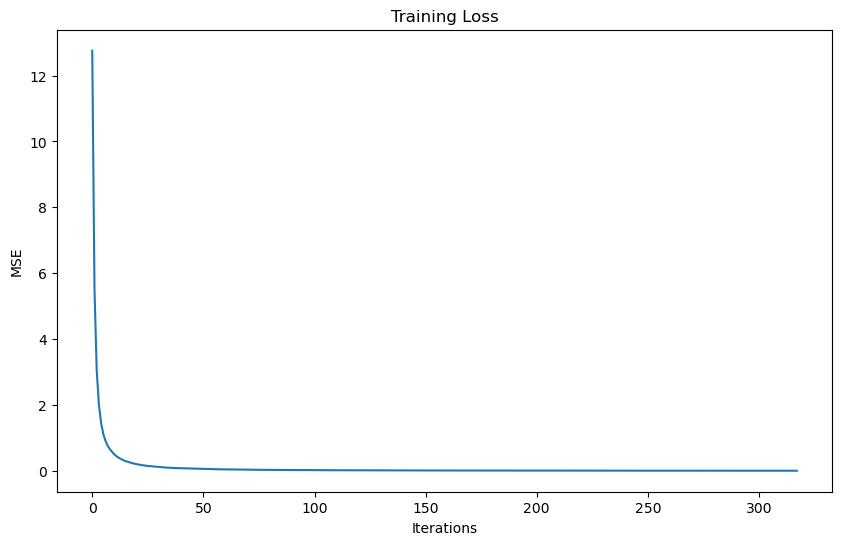

In [161]:
training_loss = spotify_model_pipelines.get('custom_gdReg_batch').steps[1][1].cost_history_
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label="Training Loss")
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title("Training Loss")
plt.show()

Test set results

In [162]:
for pipeline_name, pipeline in spotify_model_pipelines.items():
    print_results(pipeline_name, mean_squared_error(y_test, pipeline.predict(X_test)), pipeline.score(X_test, y_test))

Model: custom_linReg
MSE: 0.00172731
Score: 0.734714
------------------------------------------
Model: linReg
MSE: 0.00172731
Score: 0.734714
------------------------------------------
Model: custom_gdReg
MSE: 0.209423
Score: -31.164
------------------------------------------
Model: custom_gdReg_batch
MSE: 0.00575086
Score: 0.116763
------------------------------------------
Model: sgdReg
MSE: 0.00178779
Score: 0.725425
------------------------------------------


#### With cross-validation (KFold with three splits)

In [167]:
@dataclass
class KFoldResult:
    train_mse_scores: list[float]
    train_r2_scores: list[float]
    test_mse_scores: list[float]
    test_r2_scores: list[float]

def train_with_k_fold(pipelines) -> dict[str, KFoldResult]:
    kf = KFold(n_splits=3, shuffle=True, random_state=1)
    train_mse_scores = {model_name: [] for model_name in pipelines.keys()}
    train_r2_scores = {model_name: [] for model_name in pipelines.keys()}
    test_mse_scores = {model_name: [] for model_name in pipelines.keys()}
    test_r2_scores = {model_name: [] for model_name in pipelines.keys()}

    for train_index, test_index in kf.split(X):
        X_cv_train, X_cv_val = X.iloc[train_index], X.iloc[test_index]
        y_cv_train, y_cv_val = y.iloc[train_index], y.iloc[test_index]
        y_cv_train = y_cv_train.fillna(df[target].median())
        y_cv_val = y_cv_val.fillna(df[target].median())
        for pipeline_name, pipeline in pipelines.items():
            pipeline.fit(X_cv_train, y_cv_train)
            y_cv_pred = pipeline.predict(X_cv_val)
            y_cv_train_pred = pipeline.predict(X_cv_train)

            train_mse_scores[pipeline_name].append(mean_squared_error(y_cv_train, y_cv_train_pred))
            train_r2_scores[pipeline_name].append(r2_score(y_cv_train, y_cv_train_pred))
            test_mse_scores[pipeline_name].append(mean_squared_error(y_cv_val, y_cv_pred))
            test_r2_scores[pipeline_name].append(r2_score(y_cv_val, y_cv_pred))

    return {pipeline_name : KFoldResult(train_mse_scores[pipeline_name], train_r2_scores[pipeline_name], test_mse_scores[pipeline_name], test_r2_scores[pipeline_name]) for pipeline_name in pipelines.keys()}

Train the models with k_fold

In [170]:
training_results = train_with_k_fold(spotify_model_pipelines)

def print_k_fold_results(pipelines, k_fold_results: dict[str, KFoldResult], print_test: bool):
    for pipeline_name, pipeline in pipelines.items():
        current_result = k_fold_results[pipeline_name]
        if print_test:
            print_results(pipeline_name, np.mean(current_result.test_mse_scores), np.mean(current_result.test_r2_scores))
        else:
            print_results(pipeline_name, np.mean(current_result.train_mse_scores), np.mean(current_result.train_r2_scores))

Training set results


In [156]:
print_k_fold_results(spotify_model_pipelines, training_results, print_test=False)

Model: custom_linReg
MSE: 0.00164632
Score: 0.75541
------------------------------------------
Model: linReg
MSE: 0.00164632
Score: 0.75541
------------------------------------------
Model: custom_gdReg
MSE: 0.195918
Score: -28.1002
------------------------------------------
Model: custom_gdReg_batch
MSE: 0.00806727
Score: -0.192937
------------------------------------------
Model: sgdReg
MSE: 0.00174686
Score: 0.740413
------------------------------------------


Test set results

In [157]:
print_k_fold_results(spotify_model_pipelines, training_results, print_test=True)

Model: custom_linReg
MSE: 0.00171507
Score: 0.745008
------------------------------------------
Model: linReg
MSE: 0.00171507
Score: 0.745008
------------------------------------------
Model: custom_gdReg
MSE: 0.211531
Score: -30.4969
------------------------------------------
Model: custom_gdReg_batch
MSE: 0.00893277
Score: -0.341614
------------------------------------------
Model: sgdReg
MSE: 0.00179956
Score: 0.732582
------------------------------------------


#### Adding L1 and L2 regularization

Defining models with both L1 and L2 regularization

In [183]:
class CustomLinearRegressionWithL1(CustomModel):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = alpha

    def fit(self, X, y):
        X, y = self.prepare_data(X, y)
        X_design = np.c_[np.ones(X.shape[0]), X]
        I = np.eye(X_design.shape[1])
        I[0, 0] = 0

        regularized_matrix = X_design.T @ X_design + self.alpha * I
        pseudo_inverse = np.linalg.inv(regularized_matrix) @ X_design.T
        weights = pseudo_inverse @ y

        self.intercept_ = weights[0]
        self.coef_ = weights[1:]
        return self


spotify_model_pipelines_with_reg = {}

alpha = 1.0
add_spotify_model_pipeline(CustomLinearRegressionWithL1(alpha), 'custom_L1', spotify_model_pipelines_with_reg)
add_spotify_model_pipeline(Ridge(alpha=alpha), 'L1Reg', spotify_model_pipelines_with_reg)
add_spotify_model_pipeline(Lasso(alpha=alpha), 'L2Reg', spotify_model_pipelines_with_reg)
add_spotify_model_pipeline(SGDRegressor(tol=tol, learning_rate='invscaling', random_state=42, penalty='l1', alpha=alpha), 'sgdRegL1', spotify_model_pipelines_with_reg)
add_spotify_model_pipeline(SGDRegressor(tol=tol, learning_rate='invscaling', random_state=42, penalty='l2', alpha=alpha), 'sgdRegL2', spotify_model_pipelines_with_reg)

Train the models with K-fold

In [184]:
training_results_with_reg = train_with_k_fold(spotify_model_pipelines_with_reg)

Weights before and after L1 regularisation for linear regression

In [187]:
print("Before:")
weights_before = spotify_model_pipelines['custom_linReg'].steps[1][1].coef_
print(weights_before)
print("After:")
weights_after = spotify_model_pipelines_with_reg['custom_L1'].steps[1][1].coef_
print(weights_after)
print("Difference:")
print(weights_after - weights_before)

Before:
[ 3.72842351e-03  1.97439516e-02  5.78684545e-04 -1.74049333e-03
 -6.81161931e-04 -3.34058098e-04 -2.13727040e-03  2.55843358e-04
  7.04729932e-04  1.73371801e-03  4.46074249e-03 -5.78884581e-03
  1.51229081e-03  4.48644007e-02  4.04865093e-02  4.83542141e-02
  7.38662852e-02  5.98388389e-02  5.90355666e-02  7.46695575e-02
  7.12984803e-02  6.24066438e-02  1.12510141e-03 -2.34689297e-03
  1.12847316e-04  6.41403723e-04 -8.27341452e-04  1.40534657e-03
  5.63461297e-04 -4.35450977e-04 -1.84979927e-03 -2.10832576e-03
 -2.06395418e-03  2.82135285e-03  1.71895651e-03  4.63972684e-04
  2.15003644e-03  1.11441438e-03 -4.20552424e-04  4.14897593e-03
  3.13435257e-03  5.94070938e-04 -3.14270818e-03  6.87113169e-03
 -1.50536371e-02  3.07291237e-04  1.14674749e-03 -5.02583689e-03
 -3.62029991e-04  6.24799316e-03  7.20126015e-04  3.17939012e-03
 -4.09279357e-03 -2.00089989e-03  2.98791049e-03  5.88958144e-04
  5.25047091e-03  9.78755034e-03  4.70593034e-03  9.51360545e-03
  1.02303461e-02 

Training results

In [180]:
print_k_fold_results(spotify_model_pipelines_with_reg, training_results_with_reg, print_test=False)

Model: custom_ridge
MSE: 0.00164633
Score: 0.755408
------------------------------------------
Model: ridgeReg
MSE: 0.00164633
Score: 0.755408
------------------------------------------
Model: lassoReg
MSE: 0.00673185
Score: 0.0
------------------------------------------
Model: sgdRegL1
MSE: 0.00673279
Score: -0.000142045
------------------------------------------
Model: sgdRegL2
MSE: 0.0021217
Score: 0.684863
------------------------------------------


Test results

In [181]:
print_k_fold_results(spotify_model_pipelines_with_reg, training_results_with_reg, print_test=True)

Model: custom_ridge
MSE: 0.00171481
Score: 0.745047
------------------------------------------
Model: ridgeReg
MSE: 0.00171481
Score: 0.745047
------------------------------------------
Model: lassoReg
MSE: 0.00673588
Score: -0.000882451
------------------------------------------
Model: sgdRegL1
MSE: 0.00673351
Score: -0.000546611
------------------------------------------
Model: sgdRegL2
MSE: 0.00216187
Score: 0.678562
------------------------------------------


## Regression model in PyTorch

In [25]:
raise Exception
from torch import tensor, nn, no_grad, float32
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = tensor(spotify_preprocessor.fit_transform(X_train), dtype=float32)
y_train_tensor = tensor(y_train.values, dtype=float32)

X_test_tensor = tensor(spotify_preprocessor.fit_transform(X_test), dtype=float32)
y_test_tensor = tensor(y_test.values, dtype=float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

In [31]:
import torch
import copy
from torch.utils.data import random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.manual_seed(42)
np.random.seed(42)

n_features = X_train_tensor.shape[1]
torch_model = nn.Linear(n_features, 1)
criterion = nn.MSELoss()
optimizer = AdamW(torch_model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
batch_size = 64

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size)

In [32]:
def train_epoch(model, data_loader, criterion, optimizer, device) -> float:
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in data_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    return running_loss / len(data_loader.dataset)

def validate(model, data_loader, criterion, device) -> tuple[float, float]:
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []
    with no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            running_loss += loss.item() * X_batch.size(0)
            all_predictions.extend(y_pred.cpu().numpy().flatten())
            all_targets.extend(y_batch.cpu().numpy().flatten())
    y_true = np.array(all_targets)
    y_pred = np.array(all_predictions)
    r2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)
    return running_loss / len(data_loader.dataset), r2


num_epochs = 300
patience = 30
best_val_loss = float('inf')
counter = 0
test_losses = []
train_losses, val_losses, r2_scores = [], [], []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_model_state = None
for epoch in range(num_epochs):
    train_loss = train_epoch(torch_model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    val_loss, r2 = validate(torch_model, val_loader, criterion, device)
    val_losses.append(val_loss)
    r2_scores.append(r2)

    scheduler.step(val_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, R^2: {r2:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = copy.deepcopy(torch_model.state_dict())
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

torch_model.load_state_dict(best_model_state)
torch_model.eval()

Epoch 5/300, Train Loss: 0.0024, Val Loss: 0.0024, R^2: 0.640614
Epoch 10/300, Train Loss: 0.0023, Val Loss: 0.0024, R^2: 0.648015
Epoch 15/300, Train Loss: 0.0023, Val Loss: 0.0023, R^2: 0.660387
Epoch 20/300, Train Loss: 0.0023, Val Loss: 0.0023, R^2: 0.663774
Epoch 25/300, Train Loss: 0.0023, Val Loss: 0.0023, R^2: 0.657598
Epoch 30/300, Train Loss: 0.0022, Val Loss: 0.0023, R^2: 0.666322
Epoch 35/300, Train Loss: 0.0022, Val Loss: 0.0023, R^2: 0.667090
Epoch 40/300, Train Loss: 0.0022, Val Loss: 0.0022, R^2: 0.671692
Epoch 45/300, Train Loss: 0.0022, Val Loss: 0.0023, R^2: 0.660935
Epoch 50/300, Train Loss: 0.0022, Val Loss: 0.0022, R^2: 0.673345
Epoch 55/300, Train Loss: 0.0022, Val Loss: 0.0022, R^2: 0.675762
Epoch 60/300, Train Loss: 0.0022, Val Loss: 0.0022, R^2: 0.674993
Epoch 65/300, Train Loss: 0.0022, Val Loss: 0.0022, R^2: 0.675580
Epoch 70/300, Train Loss: 0.0022, Val Loss: 0.0022, R^2: 0.675614
Epoch 75/300, Train Loss: 0.0022, Val Loss: 0.0022, R^2: 0.675627
Epoch 80/30

Linear(in_features=22, out_features=1, bias=True)

#

#### Training set results

In [33]:
train_loss, train_r2 = validate(torch_model,
                              DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size), criterion, device)
print(f"Train Loss: {train_loss:.6}, Train R^2: {train_r2:.6}")

Train Loss: 0.00217757, Train R^2: 0.679196


#### Test set results

In [34]:
test_loss, test_r2 = validate(torch_model,
                              DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size), criterion, device)
print(f"Test Loss: {test_loss:.6}, Test R^2: {test_r2:.6}")

Test Loss: 0.00215854, Test R^2: 0.668483


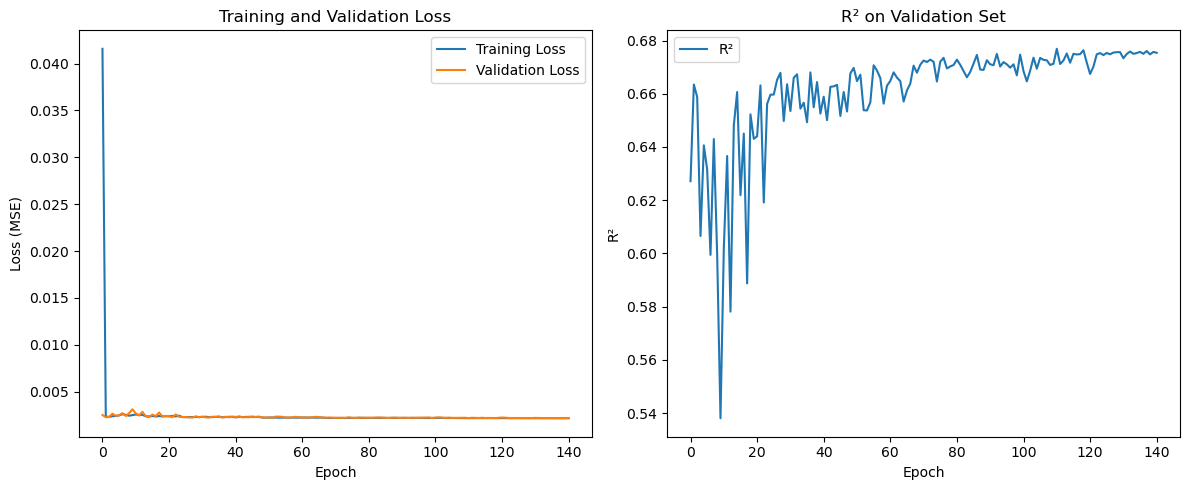

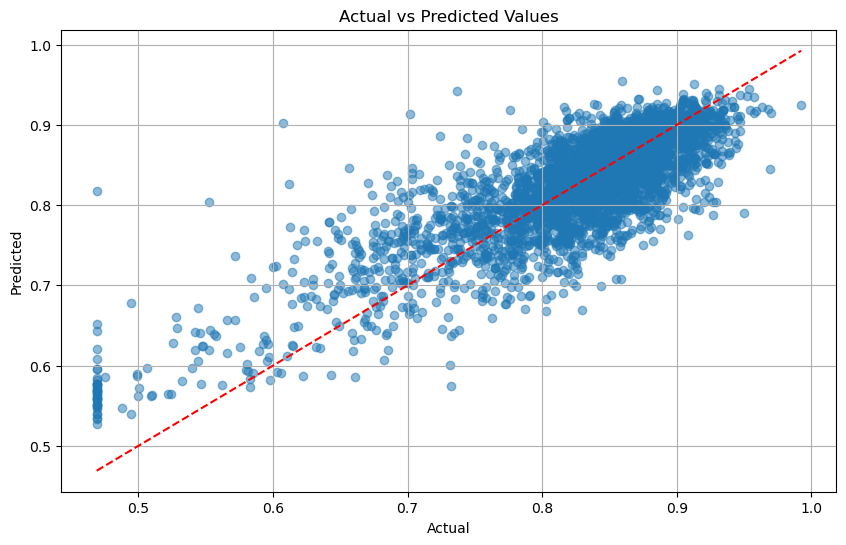

In [30]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(r2_scores, label='R²')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('R² on Validation Set')
plt.legend()

plt.tight_layout()
plt.show()

with torch.no_grad():
    test_predictions = torch_model(X_test_tensor).squeeze().numpy()

plt.figure(figsize=(10, 6))
plt.scatter(y_test_tensor.numpy(), test_predictions, alpha=0.5)
plt.plot([y_test_tensor.min(), y_test_tensor.max()], [y_test_tensor.min(), y_test_tensor.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.show()
